In [1]:
import numpy as np
import seaborn as sns;
from matplotlib import pyplot as plt
from sklearn import datasets
import itertools

from pycpd import RigidRegistration
from pycpd import AffineRegistration
from pycpd import DeformableRegistration
from sklearn.ensemble import RandomForestClassifier

In [2]:
def make_XOR(n_samples=100, cluster_center=[0,0], cluster_std=0.25, dist_from_center=0.5,
             N_XOR=False, theta_rotation=0, random_state=None):
    
    #variable setup
    seed = random_state
    dist = dist_from_center
    std = cluster_std
    n = int(n_samples/4)
    
    cluster_centers = np.array(list(itertools.product([dist, -dist], repeat=2)))
    cluster_centers = cluster_center - cluster_centers
    n_per_cluster = np.full(shape=2, fill_value=n)

    #make blobs
    X1,_ = datasets.make_blobs(n_samples=n_per_cluster, n_features=2, centers=cluster_centers[[0,3], :], 
                               cluster_std=std, random_state=seed)
    X2,_ = datasets.make_blobs(n_samples=n_per_cluster, n_features=2, centers=cluster_centers[[1,2], :], 
                               cluster_std=std, random_state=seed)
    
    #assign classe
    if N_XOR:
        y1, y2 = -np.ones(n*2), np.ones(n*2)
    else:
        y1, y2 = np.ones(n*2), -np.ones(n*2)

    X = np.concatenate((X1, X2))
    y = np.concatenate((y1, y2))

    #rotation
    c, s = np.cos(theta_rotation), np.sin(theta_rotation)
    R = np.array([[c, -s], [s, c]])
    X = (R @ X.T).T
    
    return X,y

def make_grid(X, h = 0.05, buffer = 1):
    #todo
    return True

In [38]:
#Make XOR1 and 2
X1, y1 = make_XOR(n_samples=1000)
X2, y2 = make_XOR(n_samples=1000, theta_rotation=np.pi/3)

#Grid Setup for XOR1
h = 0.10 
g = 30
x1_min, x1_max = X1[:,0].min()-1, X1[:,0].max()+1 
y1_min, y1_max = X1[:,1].min()-1, X1[:,1].max()+1 
#xx1, yy1 = np.meshgrid(np.linspace(x1_min, x1_max, g), np.linspace(y1_min, y1_max, g))
xx1, yy1 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(y1_min, y1_max, h))
G1 = np.c_[xx1.ravel(), yy1.ravel()]

#Grid Setup for XOR2
x2_min, x2_max = X2[:,0].min()-1, X2[:,0].max()+1 
y2_min, y2_max = X2[:,1].min()-1, X2[:,1].max()+1 
#xx2, yy2 = np.meshgrid(np.linspace(x2_min, x2_max, g), np.linspace(y2_min, y2_max, g))
xx2, yy2 = np.meshgrid(np.arange(x2_min, x2_max, h), np.arange(y2_min, y2_max, h))
G2 = np.c_[xx2.ravel(), yy2.ravel()]

#Predicting for XOR1
clf = RandomForestClassifier(n_estimators=500, max_depth=20)
ZZ1 = clf.fit(X1,y1).predict_proba(G1)

#Predicting for XOR2
clf = RandomForestClassifier(n_estimators=500, max_depth=20)
ZZ2 = clf.fit(X2,y2).predict_proba(G2)

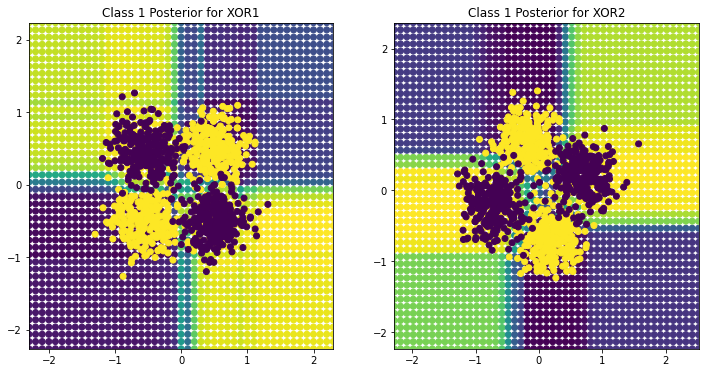

In [39]:
#Plot the decision boundary for XOR1
plt.figure(figsize=(12,6));
plt.subplot(121)
plt.scatter(G1[:,0], G1[:,1], c=ZZ1[:,0])
plt.scatter(X1[:,0], X1[:,1], c=y1) 
plt.xlim(xx1.min(), xx1.max()); plt.ylim(yy1.min(), yy1.max());
plt.title('Class 1 Posterior for XOR1');

#Plot the decision boundary for XOR2
plt.subplot(122)
plt.scatter(G2[:,0], G2[:,1], c=ZZ2[:,0])
plt.scatter(X2[:,0], X2[:,1], c=y2)
plt.xlim(xx2.min(), xx2.max()); plt.ylim(yy2.min(), yy2.max());
plt.title('Class 1 Posterior for XOR2');

In [40]:
#Registration
template = np.c_[G1,ZZ1[:,0]]
target = np.c_[G2,ZZ2[:,0]]

af_reg = DeformableRegistration(X=target, Y=template, max_iterations=50)
deformed_template = af_reg.register(template)

In [44]:
pt = [1,1, 0.9]

deformed_pt =  af_reg.register(pt)

Text(0.5, 1.0, 'deformed_template')

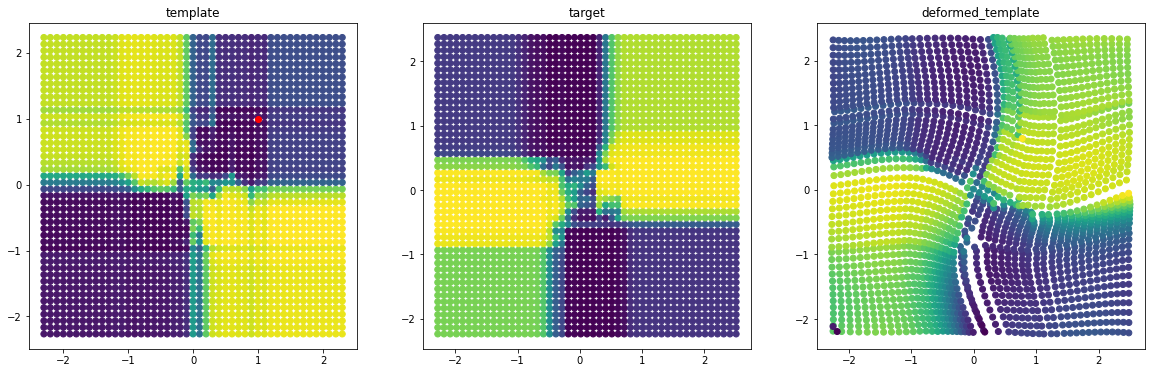

In [50]:
#plot
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.scatter(G1[:,0], G1[:,1], c=ZZ1[:,0])
plt.scatter(pt[0], pt[1], c='red')
plt.title("template")

plt.subplot(132)
plt.scatter(G2[:,0], G2[:,1], c=ZZ2[:,0])
plt.title("target")

z = deformed_template[0]
d_pt = deformed_pt[0]

plt.subplot(133)
plt.scatter(z[:,0], z[:,1], c=z[:,2])
plt.scatter(d_pt[:,0], d_pt:,[1], c=d_pt[2])
plt.title("deformed_template")

In [51]:
d_pt

array([[-2.25449189, -2.1882405 ,  0.77507954],
       [-2.11642095, -2.19459163,  0.79354662],
       [-1.97858135, -2.1992686 ,  0.81098829],
       ...,
       [ 2.20884599,  2.33843822,  0.90136109],
       [ 2.33265331,  2.33549937,  0.89815157],
       [ 2.45906361,  2.33036055,  0.89528596]])